In [1]:
! pip install statsmodels

You should consider upgrading via the 'c:\users\saidj\onedrive\documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('pruebillas.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:
import numpy as np
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from backbone.probability_transformer import ProbabilityTransformer 
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from backbone.utils import load_function
from typing import Tuple
import yaml
from sklearn.metrics import classification_report
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from tqdm import tqdm
from statsmodels.tsa.filters.hp_filter import hpfilter
import os
pd.options.display.max_rows = 999

In [3]:
# Función para calcular la volatilidad diaria
def get_daily_volatility(close_prices, span=100):
    returns = close_prices.pct_change()
    volatility = returns.ewm(span=span).std()
    return volatility

# Función para aplicar el filtro CUSUM
def apply_cusum_filter(raw_price, threshold):
    """
    :param raw_price: (series) of close prices.
    :param threshold: (float) when the abs(change) is larger than the threshold, the
    function captures it as an event.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

# Función para aplicar el método de triple barrera con filtro CUSUM
def apply_triple_barrier(
    close_prices, 
    max_prices, 
    min_prices, 
    take_profit_in_pips, 
    stop_loss_in_pips, 
    side,
    max_holding_period=50, 
    pip_size=0.0001
    ):

    barriers = []

    for index in range(len(close_prices)):
        if side[index] == 1:
            # Para una señal de compra
            upper_barrier_level = close_prices[index] * (1 + (take_profit_in_pips * pip_size))
            lower_barrier_level = close_prices[index] * (1 - (stop_loss_in_pips * pip_size))
        elif side[index] == -1:
            # Para una señal de venta
            upper_barrier_level = close_prices[index] * (1 + (stop_loss_in_pips * pip_size))
            lower_barrier_level = close_prices[index] * (1 - (take_profit_in_pips * pip_size))
        else:
            # Si no hay señal, saltar al siguiente índice
            continue
        
        # Evaluar los precios futuros dentro del período máximo de mantenimiento
        for j in range(index + 1, min(index + max_holding_period, len(close_prices))):
            if side[index] == 1:
                # Señal de compra: tomar ganancias si se alcanza la barrera superior
                if close_prices[j] >= upper_barrier_level or max_prices[j] >= upper_barrier_level:
                    barriers.append((index, 1))  # Etiqueta 1 para toma de ganancias
                    break
                elif close_prices[j] <= lower_barrier_level or min_prices[j] <= lower_barrier_level:
                    barriers.append((index, 0))  # Etiqueta 0 para stop-loss
                    break
            elif side[index] == -1:
                # Señal de venta: tomar ganancias si se alcanza la barrera inferior
                if close_prices[j] <= lower_barrier_level or min_prices[j] <= lower_barrier_level:
                    barriers.append((index, 1))  # Etiqueta 1 para toma de ganancias
                    break
                elif close_prices[j] >= upper_barrier_level or max_prices[j] >= upper_barrier_level:
                    barriers.append((index, 0))  # Etiqueta 0 para stop-loss
                    break
        else:
            barriers.append((index, 2))  # Etiqueta 2 si no se alcanza ninguna barrera
    
    # Revisar los eventos etiquetados como 2 para determinar si son ganancias o pérdidas
    for idx, (event_index, label) in enumerate(barriers):
        if label == 2:
            # Determinar si el precio final fue una ganancia o una pérdida
            final_price = close_prices[min(event_index + max_holding_period, len(close_prices) - 1)]
            initial_price = close_prices[event_index]
            
            if side[event_index] == 1:
                # Para una señal de compra
                if final_price >= initial_price:
                    barriers[idx] = (event_index, 1)  # Etiqueta 1 para toma de ganancias
                elif final_price < initial_price:
                    barriers[idx] = (event_index, 0)  # Etiqueta 0 para stop-loss
            elif side[event_index] == -1:
                # Para una señal de venta
                if final_price <= initial_price:
                    barriers[idx] = (event_index, 1)  # Etiqueta 1 para toma de ganancias
                elif final_price > initial_price:
                    barriers[idx] = (event_index, 0)  # Etiqueta 0 para stop-loss

    return barriers

# Función principal que usa el método de triple barrera con filtro CUSUM
def triple_barrier_labeling(
        close_prices, 
        max_prices, 
        min_prices,  
        take_profit_in_pips, 
        stop_loss_in_pips, 
        side,
        max_holding_period=50, 
        pip_size=0.0001,
    ):

    
    labels = apply_triple_barrier(
        close_prices,
        max_prices,
        min_prices,
        take_profit_in_pips, 
        stop_loss_in_pips, 
        side,
        max_holding_period, 
        pip_size
    )
    
    target = [label for _, label in labels]
    return target


In [64]:
symbols_path = './backbone/data/backtest/symbols/EURUSD.csv'
df = pd.read_csv(symbols_path)

print('Creando target')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')
df = df.set_index('Date')

instrument = df.copy()
# compute bband sides

instrument['side'] = np.nan

# long_signals = (instrument['Close'] <= instrument['lower_bband'])
# short_signals = (instrument['Close'] >= instrument['upper_bband'])
# instrument.loc[long_signals, 'side'] = 1
# instrument.loc[short_signals, 'side'] = -1

# compute macd sides
# long_signals = (instrument['macd'] > instrument['macdsignal']) & (instrument['macd'].shift(1) <= instrument['macdsignal'].shift(1))
# instrument.loc[long_signals, 'side'] = 1
# short_signals = (instrument['macd'] < instrument['macdsignal']) & (instrument['macd'].shift(1) >= instrument['macdsignal'].shift(1))
# instrument.loc[short_signals, 'side'] = -1

cycle, trend = hpfilter(instrument['Close'], lamb=1000)
instrument['trend'] = trend
instrument['SMA20'] = instrument['trend'].rolling(window=20).mean()
# instrument['SMA200'] = instrument['trend'].rolling(window=200).mean()
long_signals = (instrument['trend'] > instrument['SMA20']) & (instrument['trend'].shift(1) <= instrument['SMA20'].shift(1))
short_signals = (instrument['trend'] < instrument['SMA20']) & (instrument['trend'].shift(1) >= instrument['SMA20'].shift(1))
instrument.loc[long_signals, 'side'] = 1
instrument.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
instrument['side'] = instrument['side'].shift(1)

# Drop the NaN values from our data set
# volatility = get_daily_volatility(instrument.Close, span=120)

# cusum_events = apply_cusum_filter(instrument.Close, threshold=volatility.mean()*0.25)

# instrument = instrument.loc[cusum_events]

instrument.dropna(inplace=True)

print(instrument.side.value_counts())

instrument['target'] = triple_barrier_labeling(
    close_prices=instrument['Close'], 
    min_prices=instrument['Low'], 
    max_prices=instrument['High'], 
    take_profit_in_pips=30, 
    stop_loss_in_pips=15, 
    max_holding_period=24, 
    pip_size=0.0001,
    side=instrument['side']
)


Creando target
side
 1.0    181
-1.0    180
Name: count, dtype: int64


In [65]:
instrument['target'].value_counts()

target
1    238
0    123
Name: count, dtype: int64

In [66]:
df.loc[instrument.index, 'side'] = instrument.side
df.loc[instrument.index, 'target'] = instrument.target
df.fillna(0, inplace=True)
df.reset_index(inplace=True)

In [67]:
df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month

# Accuracy

In [69]:
instrument[(instrument.side != 0) & (instrument.target==1)].shape[0] / instrument[(instrument.side!=0)].shape[0]

0.6592797783933518

In [8]:
# import pandas as pd
# import os
# pd.set_option('display.max_columns', None)

# periods_forward = 5

# tickers = ['EURUSD']
# symbols_path = './backbone/data/backtest/symbols'
# instruments = {}
# df = pd.DataFrame()

# for ticker in tickers:
#     instruments[ticker] = pd.read_csv(os.path.join(symbols_path, f'{ticker}.csv'))
  
#     instruments[ticker]['ticker'] = ticker
  
#     print('Creando target')
   
#     instruments[ticker] = instruments[ticker].sort_values(by='Date')

#     instruments[ticker]['target'] = triple_barrier_labeling(instruments[ticker], upper_barrier=0.015, lower_barrier=0.015, max_holding_period=48, span=100)
    
#     df = pd.concat([
#         df,
#         instruments[ticker]
#     ])

#     df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:00:00')

#     df = df.sort_values(by='Date')

In [2]:
df = pd.read_csv('./backbone/data/backtest/symbols/dataset.csv')

In [3]:
date_format = '%Y-%m-%d %H:00:00'
window = 11520

actual_date = datetime(2024,5,1,0,0,0)

date_to = actual_date - timedelta(hours=24+1) 
date_from = date_to - timedelta(hours=window)

date_from_test = actual_date
date_to_test = date_from_test + timedelta(hours=1440)

date_from_str = date_from.strftime(date_format)
date_to_str = date_to.strftime(date_format)
date_from_test_str = date_from_test.strftime(date_format)
date_to_test_str = date_to_test.strftime(date_format)


train = df[(df['Date']>date_from_str) & (df['Date']<date_to_str) & (df.side != 0)]
test = df[(df['Date']>date_from_test_str) & (df['Date']<date_to_test_str) & (df.side != 0)]

# Inicio undersampling
# class_0 = train[train['target']==0]
# class_2 = train[train['target']==2]
# avg_examples = (class_0.shape[0] + class_2.shape[0]) / 2
# class_1 = train[train['target']==1].tail(int(avg_examples)).sample(frac=1)

# train = pd.concat([class_0, class_1, class_2])
# fin undersampling

train.target.value_counts()

target
1.0    911
0.0    410
Name: count, dtype: int64

In [4]:
test.target.value_counts()

target
1.0    109
0.0     51
Name: count, dtype: int64

In [5]:
from backbone.machine_learning_agent import MachineLearningAgent

with open('./configs/model_config.yml', 'r') as file:
    model_configs = yaml.safe_load(file)

cols_to_drop = [
  'Open',
  'High',
  'Low',
  'Close',
  'target', 
  'Date', 
  'ticker'
]

model_name = 'gradient_boosting'

param_grid = model_configs[model_name]['param_grid']
model = model_configs[model_name]['model']

mla = MachineLearningAgent(
    tickers=['EURUSD', 'GBPUSD', 'USDJPY', 'USDCAD', 'AUDUSD', 'USDCHF'], 
    model=model, 
    param_grid=param_grid
)

In [6]:
x_train = train.drop(columns=cols_to_drop)
y_train = train.target

In [7]:
y_train.value_counts()

target
1.0    911
0.0    410
Name: count, dtype: int64

In [8]:
mla.train(
    x_train = train.drop(columns=cols_to_drop),
    x_test = test.drop(columns=cols_to_drop),
    y_train = train.target,
    y_test = test.target,
    date_train=actual_date,
    verbose=True,
    undersampling=False
)

Best parameter (CV score=0.666):
Best params: {'stacking__prob_transf__model__learning_rate': 0.05, 'stacking__prob_transf__model__max_depth': 3, 'stacking__prob_transf__model__n_estimators': 15, 'stacking__prob_transf__model__objective': 'binary:logistic', 'stacking__prob_transf__model__random_state': 42}
train precision:  0.7202983061799935
train recall:  0.6207418622255867
train f1:  0.6335370336600004


# Train performance

In [9]:
classes, probas = mla.predict_proba(train.drop(columns=cols_to_drop))

precision = precision_score(train.target, classes, average='weighted')
recall = recall_score(train.target, classes, average='weighted')
f1 = f1_score(train.target, classes, average='weighted')

print(precision)
print(recall)
print(f1) 

# target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(train.target, classes))

0.7202983061799935
0.6207418622255867
0.6335370336600004
              precision    recall  f1-score   support

         0.0       0.44      0.78      0.56       410
         1.0       0.85      0.55      0.67       911

    accuracy                           0.62      1321
   macro avg       0.64      0.66      0.61      1321
weighted avg       0.72      0.62      0.63      1321



# Test performance

In [10]:
classes, probas = mla.predict_proba(test.drop(columns=cols_to_drop))

precision = precision_score(test.target, classes, average='weighted')
recall = recall_score(test.target, classes, average='weighted')
f1 = f1_score(test.target, classes, average='weighted')

print(precision)
print(recall)
print(f1) 

# target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test.target, classes))

0.69697265625
0.58125
0.5908826825527899
              precision    recall  f1-score   support

         0.0       0.42      0.78      0.54        51
         1.0       0.83      0.49      0.61       109

    accuracy                           0.58       160
   macro avg       0.62      0.64      0.58       160
weighted avg       0.70      0.58      0.59       160



In [45]:
binary_probas = np.where(classes == 0, 1-probas, probas)
binary_probas

array([0.56022815, 0.55082354, 0.50557515, 0.55082354, 0.52867405,
       0.55082354, 0.4059493 , 0.61017602, 0.4557834 , 0.52179368,
       0.4557834 , 0.51165662, 0.4557834 , 0.46706189, 0.4557834 ,
       0.44505992, 0.49837506, 0.49837506, 0.52179368, 0.54430971,
       0.50237604, 0.4557834 , 0.51165662, 0.49837506, 0.4557834 ,
       0.49837506, 0.49837506, 0.49837506, 0.46706189, 0.44721178,
       0.44721178, 0.46706189, 0.4557834 , 0.54430971, 0.49837506,
       0.47711913, 0.59232572, 0.49837506, 0.47711913, 0.47711913,
       0.49837506, 0.52179368, 0.4557834 ])

In [88]:
test['pred_label'] = np.nan
test['proba'] = np.nan

cols_to_drop += ['pred_label', 'proba']
side = (test.side != 0).any()

for index, stock in test.iterrows():
  
  if side:
      # Drop the specified columns before prediction
      stock_features = stock.drop(labels=cols_to_drop)
      
      stock_features_df = pd.DataFrame([stock_features])

      # Predict the class and probability
      _class, proba = mla.predict_proba(stock_features_df)
      
      # Assign the predicted class and probability to the DataFrame
      test.at[index, 'pred_label'] = _class
      test.at[index, 'proba'] = proba


C:\Users\SaidJ\AppData\Local\Temp\ipykernel_1672\669063084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_label'] = np.nan
C:\Users\SaidJ\AppData\Local\Temp\ipykernel_1672\669063084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['proba'] = np.nan


In [90]:
precision = precision_score(test.target, test.pred_label, average='weighted')
recall = recall_score(test.target, test.pred_label, average='weighted')
f1 = f1_score(test.target, test.pred_label, average='weighted')

print(precision)
print(recall)
print(f1) 

# target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(test.target, test.pred_label))

0.733634797588286
0.5813953488372093
0.5909504550050556
              precision    recall  f1-score   support

         0.0       0.41      0.85      0.55        13
         1.0       0.88      0.47      0.61        30

    accuracy                           0.58        43
   macro avg       0.64      0.66      0.58        43
weighted avg       0.73      0.58      0.59        43



In [74]:
test_results = {}
test_results['EURUSD'] = {}
test_results['USDJPY'] = {}
test_results['USDCAD'] = {}
test_results['EURUSD']['2021-01-01']={}
test_results['USDJPY']['2021-01-01']={}
test_results['USDCAD']['2021-01-01']={}

test_results['EURUSD']['2021-01-02']={}
test_results['USDJPY']['2021-01-02']={}
test_results['USDCAD']['2021-01-02']={}

In [75]:
test_results['EURUSD']['2021-01-01']['y_true'] = 1
test_results['EURUSD']['2021-01-01']['y_pred'] = 0
test_results['EURUSD']['2021-01-01']['y_proba'] = 0.2

test_results['USDJPY']['2021-01-01']['y_true'] = 1
test_results['USDJPY']['2021-01-01']['y_pred'] = 0
test_results['USDJPY']['2021-01-01']['y_proba'] = 0.2

test_results['USDCAD']['2021-01-01']['y_true'] = 1
test_results['USDCAD']['2021-01-01']['y_pred'] = 0
test_results['USDCAD']['2021-01-01']['y_proba'] = 0.2

test_results['EURUSD']['2021-01-02']['y_true'] = 1
test_results['EURUSD']['2021-01-02']['y_pred'] = 0
test_results['EURUSD']['2021-01-02']['y_proba'] = 0.2

test_results['USDJPY']['2021-01-02']['y_true'] = 1
test_results['USDJPY']['2021-01-02']['y_pred'] = 0
test_results['USDJPY']['2021-01-02']['y_proba'] = 0.2

test_results['USDCAD']['2021-01-02']['y_true'] = 1
test_results['USDCAD']['2021-01-02']['y_pred'] = 0
test_results['USDCAD']['2021-01-02']['y_proba'] = 0.2

In [76]:
test_results

{'EURUSD': {'2021-01-01': {'y_true': 1, 'y_pred': 0, 'y_proba': 0.2},
  '2021-01-02': {'y_true': 1, 'y_pred': 0, 'y_proba': 0.2}},
 'USDJPY': {'2021-01-01': {'y_true': 1, 'y_pred': 0, 'y_proba': 0.2},
  '2021-01-02': {'y_true': 1, 'y_pred': 0, 'y_proba': 0.2}},
 'USDCAD': {'2021-01-01': {'y_true': 1, 'y_pred': 0, 'y_proba': 0.2},
  '2021-01-02': {'y_true': 1, 'y_pred': 0, 'y_proba': 0.2}}}

In [77]:
df_results = pd.DataFrame()

for ticker, values in test_results.items():
    for date, values2 in values.items():
        single_line_df = pd.DataFrame(
            {
                'ticker':[ticker], 
                'date':[date], 
                'y_true':values2['y_true'], 
                'y_pred':values2['y_pred'], 
                'proba':values2['y_proba'],
            }
        )

        df_results = pd.concat([df_results, single_line_df])

df_results
           

,ticker,date,y_true,y_pred,proba
0,EURUSD,2021-01-01,1,0,0.2
0,EURUSD,2021-01-02,1,0,0.2
0,USDJPY,2021-01-01,1,0,0.2
0,USDJPY,2021-01-02,1,0,0.2
0,USDCAD,2021-01-01,1,0,0.2
0,USDCAD,2021-01-02,1,0,0.2


In [61]:
df

EURUSD  y_pred   2021-01-01    0.0
        y_proba  2021-01-01    0.2
        y_true   2021-01-01    1.0
USDJPY  y_pred   2021-01-01    0.0
        y_proba  2021-01-01    0.2
        y_true   2021-01-01    1.0
USDCAD  y_pred   2021-01-01    0.0
        y_proba  2021-01-01    0.2
        y_true   2021-01-01    1.0
dtype: float64

USDCAD


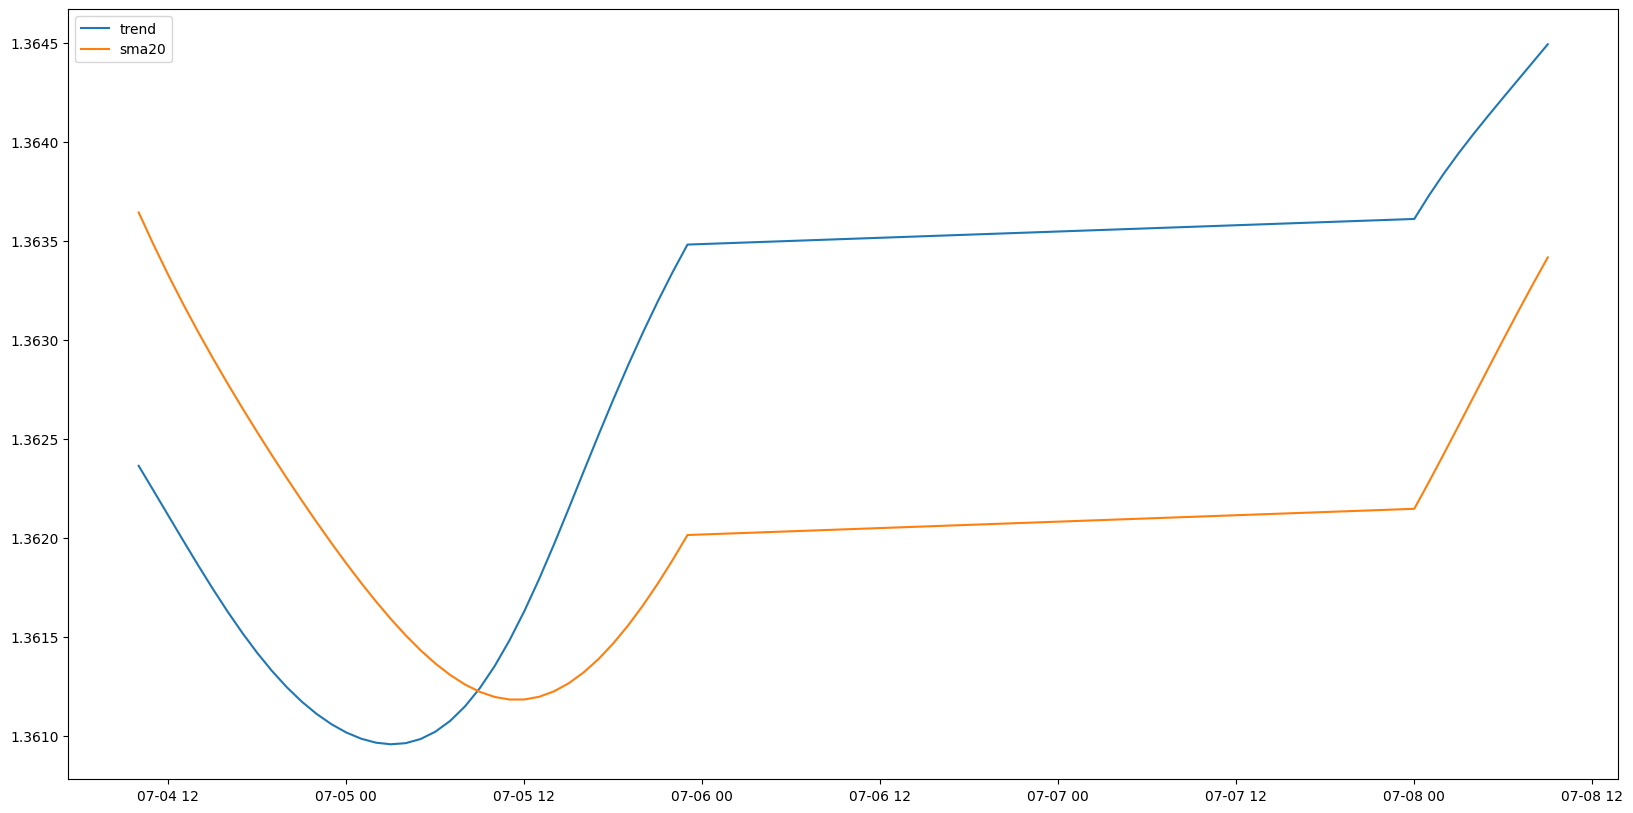

In [22]:
import time
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

df = pd.read_csv('./backbone/data/trading/symbols/dataset.csv')


for ticker in df.ticker.unique():
    print(ticker)
    df_ticker = df[df['ticker']==ticker].tail(48)
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Datos de ejemplo
    x = pd.to_datetime(df_ticker['Date'])
    trend = df_ticker['trend']  # Datos para la línea
    sma20 = df_ticker['SMA20']  # Datos para la línea
    
    # Crear una figura y ejes
    
    # Agregar la línea
    ax.plot(x, trend, label='trend')
    ax.plot(x, sma20, label='sma20')
        
    ax.legend()
        
        # Mostrar el gráfico
        # print(path)
    plt.show()
    a = input()
    
    clear_output(wait=True)

In [24]:
df[(df['side']!=0)].tail()[['Date','ticker','side']]

,Date,ticker,side
48414,2024-07-03 00:00:00,EURUSD,1.0
48451,2024-07-03 06:00:00,USDCHF,-1.0
48517,2024-07-03 17:00:00,USDJPY,-1.0
48758,2024-07-05 09:00:00,USDCAD,1.0
48886,2024-07-08 06:00:00,EURUSD,-1.0


In [15]:
df[(df['side']!=0)].tail()[['Date','ticker','side']]

,Date,ticker,side
48498,2024-07-03 17:00:00,USDJPY,-1.0
48742,2024-07-05 09:00:00,USDCAD,1.0
48882,2024-07-08 09:00:00,USDJPY,1.0
48899,2024-07-08 12:00:00,AUDUSD,-1.0
48913,2024-07-08 14:00:00,USDCAD,-1.0


In [25]:
df_nuevo = pd.read_csv('./backbone/data/trading/symbols/dataset_actual.csv')
df_viejo = pd.read_csv('./backbone/data/trading/symbols/dataset.csv')


In [34]:
df_nuevo.tail(25)[['Date','ticker','Close','trend','SMA20','side','target']]

,Date,ticker,Close,trend,SMA20,side,target
48898,2024-07-08 11:00:00,GBPUSD,1.28191,1.281979,1.280800,0.0,0.0
48899,2024-07-08 12:00:00,AUDUSD,0.67412,0.674379,0.674381,-1.0,1.0
48900,2024-07-08 12:00:00,USDCAD,1.36331,1.363718,1.363532,0.0,0.0
48901,2024-07-08 12:00:00,USDCHF,0.89559,0.895333,0.895931,0.0,0.0
48902,2024-07-08 12:00:00,USDJPY,161.03500,160.820198,160.746752,0.0,0.0
48903,2024-07-08 12:00:00,GBPUSD,1.28191,1.282125,1.280937,0.0,0.0
48904,2024-07-08 12:00:00,EURUSD,1.08381,1.083340,1.082938,0.0,0.0
48905,2024-07-08 13:00:00,AUDUSD,0.67368,0.674348,0.674400,0.0,0.0
48906,2024-07-08 13:00:00,USDCHF,0.89605,0.895352,0.895833,0.0,0.0
48907,2024-07-08 13:00:00,GBPUSD,1.28167,1.282275,1.281072,0.0,0.0


In [33]:
df_viejo.tail()[['Date','ticker','Close','trend','SMA20','side','target']]

,Date,ticker,Close,trend,SMA20,side,target
48900,2024-07-08 12:00:00,EURUSD,1.08381,1.083238,1.082924,0.0,0.0
48901,2024-07-08 12:00:00,USDJPY,161.03500,160.811766,160.743607,0.0,0.0
48902,2024-07-08 12:00:00,GBPUSD,1.28191,1.281672,1.280855,0.0,0.0
48903,2024-07-08 12:00:00,AUDUSD,0.67412,0.674468,0.674406,0.0,0.0
48904,2024-07-08 12:00:00,USDCHF,0.89559,0.894696,0.895802,0.0,0.0
